# Modeling + Tuning

- GROUP STAGE MODELING

- KNOCKOUT STAGE MODELING

In [120]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [300]:
final_df = pd.read_csv('data/training.csv')
final_df.tail()

,Team1,Team2,Team1_FIFA_RANK,Team2_FIFA_RANK,Team1_Result,Team1_Goalkeeper_Score,Team2_Goalkeeper_Score,Team1_Defense,Team1_Offense,Team1_Midfield,Team2_Defense,Team2_Offense,Team2_Midfield
9316,Netherlands,Wales,10,18,1,81.0,74.0,85.0,83.0,84.0,75.0,73.0,78.0
9317,Poland,Belgium,26,2,0,87.0,89.0,75.0,85.0,76.0,81.0,86.0,86.0
9318,Chile,Ghana,28,60,0,79.0,74.0,76.0,77.0,78.0,76.0,76.0,78.0
9319,Japan,Tunisia,23,35,0,73.0,64.0,75.0,75.0,78.0,71.0,72.0,74.0
9320,Korea Republic,Egypt,29,32,1,75.0,70.0,73.0,80.0,74.0,70.0,79.0,71.0


In [301]:
final_df.shape

(9321, 13)

In [302]:
final_df.columns

Index(['Team1', 'Team2', 'Team1_FIFA_RANK', 'Team2_FIFA_RANK', 'Team1_Result',
       'Team1_Goalkeeper_Score', 'Team2_Goalkeeper_Score', 'Team1_Defense',
       'Team1_Offense', 'Team1_Midfield', 'Team2_Defense', 'Team2_Offense',
       'Team2_Midfield'],
      dtype='object')

# GROUP STAGE MODELING

### Choosing a model

In [265]:
# I save the original data frame in a flag to then train the final pipeline
pipe_DF = final_df
# Dummies for categorical columns
final_df = pd.get_dummies(final_df)

I split the dataset into training, testing and validation.

In [266]:
X = final_df.drop('Team1_Result',axis=1)
y = final_df['Team1_Result']
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.1, random_state=42)

 Scaling

In [267]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_hold_test = scaler.transform(X_hold_test)

Defining function to display the confusion matrix quickly.

In [268]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
def metrics_display(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred);

1-  **Random Forest**

              precision    recall  f1-score   support

           0       0.54      0.54      0.54        28
           1       0.62      0.80      0.70        45
           2       0.62      0.24      0.34        21

    accuracy                           0.60        94
   macro avg       0.59      0.52      0.53        94
weighted avg       0.60      0.60      0.57        94



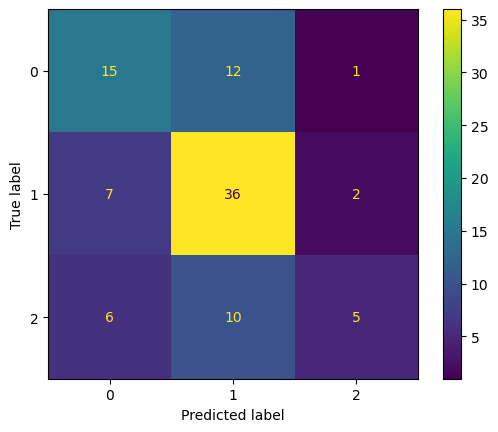

In [269]:
# Modeling packages
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
metrics_display(RandomForestClassifier())

2- **XGB Boost**

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.57      0.43      0.49        28
           1       0.56      0.84      0.67        45
           2       0.60      0.14      0.23        21

    accuracy                           0.56        94
   macro avg       0.58      0.47      0.46        94
weighted avg       0.57      0.56      0.52        94



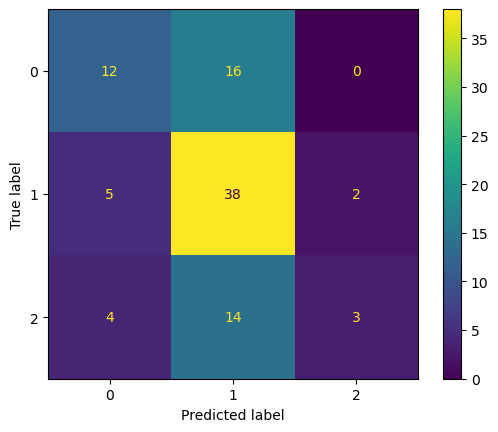

In [270]:
from xgboost import XGBClassifier
metrics_display(XGBClassifier(use_label_encoder=False))

3- **Logistic Regression**

              precision    recall  f1-score   support

           0       0.52      0.43      0.47        28
           1       0.61      0.89      0.72        45
           2       0.20      0.05      0.08        21

    accuracy                           0.56        94
   macro avg       0.44      0.46      0.42        94
weighted avg       0.49      0.56      0.50        94



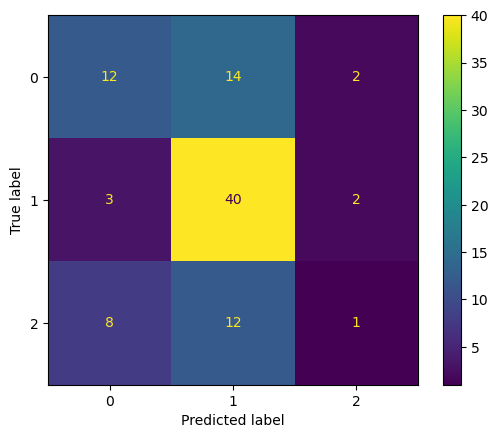

In [271]:
from sklearn.linear_model import LogisticRegression
metrics_display(LogisticRegression(solver='newton-cg'))

4- **Naive Bayes**

              precision    recall  f1-score   support

           0       1.00      0.11      0.19        28
           1       0.89      0.18      0.30        45
           2       0.24      0.95      0.39        21

    accuracy                           0.33        94
   macro avg       0.71      0.41      0.29        94
weighted avg       0.78      0.33      0.29        94



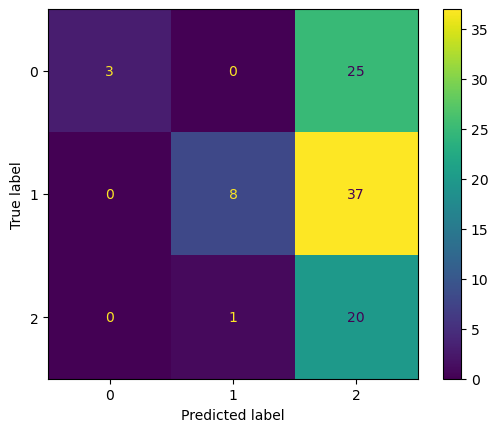

In [272]:
from sklearn.naive_bayes import GaussianNB
metrics_display(GaussianNB())

5- **Decision Tree**

              precision    recall  f1-score   support

           0       0.40      0.43      0.41        28
           1       0.68      0.60      0.64        45
           2       0.38      0.43      0.40        21

    accuracy                           0.51        94
   macro avg       0.48      0.49      0.48        94
weighted avg       0.53      0.51      0.52        94



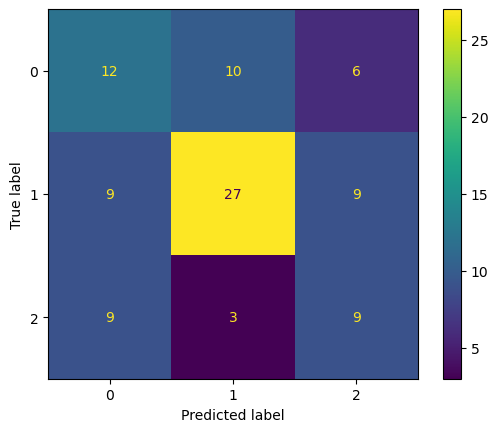

In [273]:
from sklearn.tree import DecisionTreeClassifier
metrics_display(DecisionTreeClassifier())

The Random forest and XGBoost model performs better than the others, so I will tune its hyperparameters and evaluate the performance based on the validation dataset.

### XGBoost - Tuning & Hold-out Validation

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Make a dictionary of hyperparameter values to search
search_space = {
    "n_estimators" : [200,250,300,350,400,450,500],
    "max_depth" : [3,4,5,6,7,8,9],
    "gamma" : [0.001,0.01,0.1],
    "learning_rate" : [0.001,0.01,0.1]
}

In [ ]:
# make a GridSearchCV object
GS = GridSearchCV(estimator = XGBClassifier(use_label_encoder=False),
                  param_grid = search_space,
                  scoring = 'accuracy',
                  cv = 5,
                  verbose = 4)

Uncomment the following line to enable the tuning. The best result I found was: gamma = 0.01, learning_rate = 0.01, n_estimators = 200, max_depth = 4

In [ ]:
#GS.fit(X_train,y_train)

To get only the best hyperparameter values

In [ ]:
#print(GS.best_params_) 

Initially, we validate the model with its default parameters, and then we will validate it with its tuned parameters.

* **Default Hyperparameters**

              precision    recall  f1-score   support

           0       0.51      0.58      0.54       209
           1       0.65      0.81      0.72       436
           2       0.28      0.08      0.12       194

    accuracy                           0.59       839
   macro avg       0.48      0.49      0.46       839
weighted avg       0.53      0.59      0.54       839



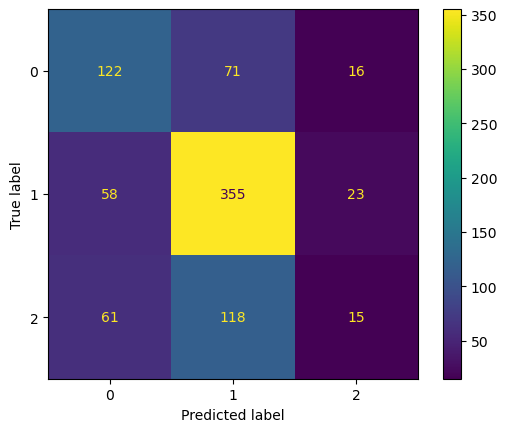

In [274]:
model = XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

* **Tuned Hyperparameters**

**XGBoost**

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.53      0.62      0.57       209
           1       0.65      0.88      0.74       436
           2       0.00      0.00      0.00       194

    accuracy                           0.61       839
   macro avg       0.39      0.50      0.44       839
weighted avg       0.47      0.61      0.53       839



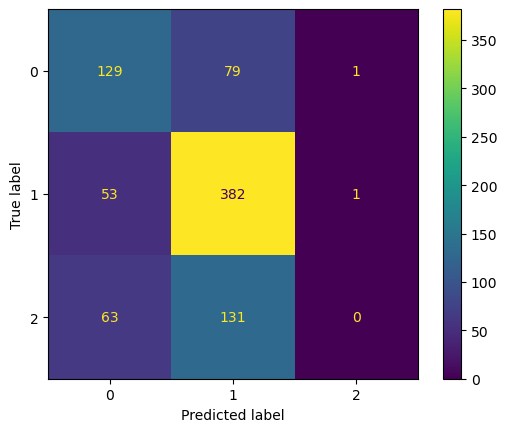

In [275]:
model = XGBClassifier(use_label_encoder = False, gamma = 0.01, learning_rate = 0.01, n_estimators = 200, max_depth = 4)
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

### Random Forest - Tuning & Hold-out Validation

**Random Forest**

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in range(200,2000,200)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

              precision    recall  f1-score   support

           0       0.50      0.61      0.55       209
           1       0.65      0.87      0.74       436
           2       0.00      0.00      0.00       194

    accuracy                           0.60       839
   macro avg       0.38      0.49      0.43       839
weighted avg       0.46      0.60      0.52       839



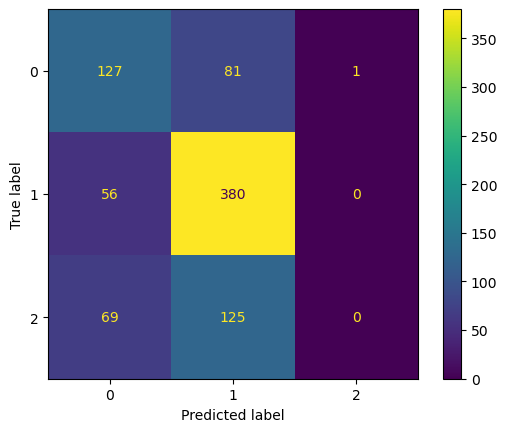

In [276]:
model1 = RandomForestClassifier(n_estimators=1600,min_samples_split=5,min_samples_leaf=4,max_features='auto',max_depth=90,bootstrap=True)
model1.fit(X_train,y_train)
y_pred = model1.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

The tuned model XgBoost is the best, so we will create a pipe to use the model later easily.

### Creating a pipeline for the XGBoost model

In [278]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(),['Team1', 'Team2']),remainder='passthrough')

pipe_X = pipe_DF.drop('Team1_Result',axis=1)
pipe_y = pipe_DF['Team1_Result']

from sklearn.pipeline import make_pipeline
pipe_League = make_pipeline(column_trans,StandardScaler(with_mean=False),XGBClassifier(use_label_encoder=False, gamma= 0.01, learning_rate= 0.01, n_estimators= 300, max_depth= 4))
pipe_League.fit(pipe_X,pipe_y)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Team1', 'Team2'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_...
                               feature_types=None, gamma=0.01, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.01,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
 

In [279]:
pipe_League1 = make_pipeline(column_trans,StandardScaler(with_mean=False),RandomForestClassifier(n_estimators=1600,min_samples_split=5,min_samples_leaf=4,max_features='auto',max_depth=90,bootstrap=True))
pipe_League1.fit(pipe_X,pipe_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Team1', 'Team2'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=90, min_samples_leaf=4,
                                        min_samples_split=5,
                                        n_estimators=1600))])

In [281]:
import joblib
joblib.dump(pipe_League,"groups_stage_prediction.pkl")

['groups_stage_prediction.pkl']

In [282]:
import joblib
joblib.dump(pipe_League1,"groups_stage_prediction1.pkl")

['groups_stage_prediction1.pkl']

# KNOCKOUT STAGE MODELING

### Choosing the model 

Removing Draw status.

In [284]:
knock_df = pipe_DF[pipe_DF['Team1_Result'] != 2]

In [285]:
pipe_knock_df = knock_df
knock_df = pd.get_dummies(knock_df)
X = knock_df.drop('Team1_Result',axis=1)
y = knock_df['Team1_Result']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.1, random_state=42)

*   **Random Forest**




              precision    recall  f1-score   support

           0       0.48      0.63      0.55        19
           1       0.85      0.76      0.80        54

    accuracy                           0.73        73
   macro avg       0.67      0.70      0.67        73
weighted avg       0.76      0.73      0.74        73



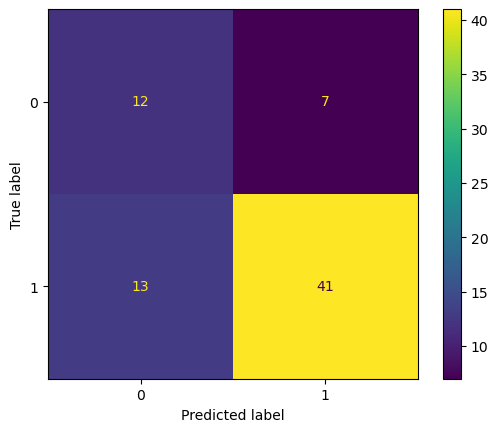

In [286]:
metrics_display(RandomForestClassifier())

* **XGBoost**

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.59      0.68      0.63        19
           1       0.88      0.83      0.86        54

    accuracy                           0.79        73
   macro avg       0.74      0.76      0.75        73
weighted avg       0.81      0.79      0.80        73



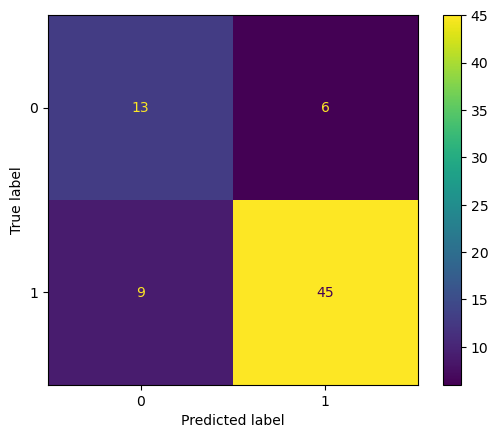

In [287]:
metrics_display(XGBClassifier(use_label_encoder=False))

              precision    recall  f1-score   support

           0       0.48      0.53      0.50        19
           1       0.83      0.80      0.81        54

    accuracy                           0.73        73
   macro avg       0.65      0.66      0.66        73
weighted avg       0.74      0.73      0.73        73



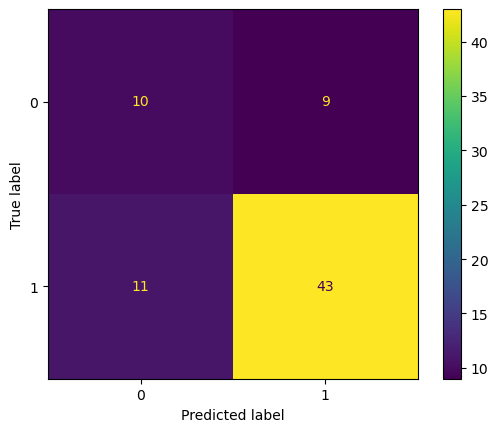

In [288]:
metrics_display(LogisticRegression(solver='newton-cg'))

All models have very similar performance. Therefore we will tune the Random Forest model and the XGBoost.

### Random Forest - Tuning & Hold-out Validation 

In [41]:
search_space = {
    "max_depth" : [11,12,13,14,15,16],
    "max_leaf_nodes" : [170,180,190,200,210,220,230],
    "min_samples_leaf" : [3,4,5,6,7,8],
    "n_estimators" : [310,320,330,340,350]
}

In [32]:
GS = GridSearchCV(estimator = RandomForestClassifier(),
                  param_grid = search_space,
                  scoring = 'accuracy',
                  cv = 5,
                  verbose = 4)

Uncomment the following lines to enable the tuning. The best result I found was: max_depth = 16, n_estimators = 320, max_leaf_nodes = 190, min_samples_leaf = 5

In [33]:
#GS.fit(X_train,y_train)

In [34]:
#print(GS.best_params_)

* **Default Hyperparameters**

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       242
           1       0.80      0.81      0.80       407

    accuracy                           0.75       649
   macro avg       0.73      0.73      0.73       649
weighted avg       0.75      0.75      0.75       649



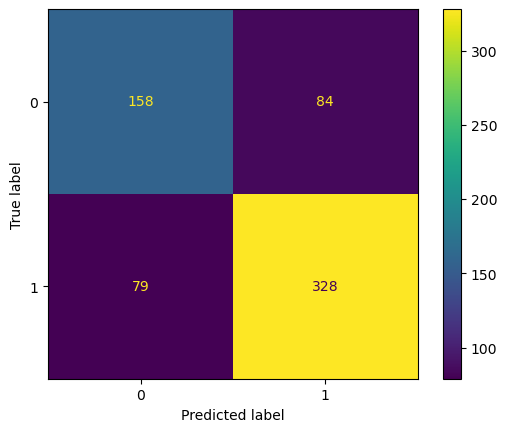

In [289]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

* **Tuned Hyperparameters**

              precision    recall  f1-score   support

           0       0.75      0.64      0.69       242
           1       0.80      0.87      0.84       407

    accuracy                           0.78       649
   macro avg       0.77      0.75      0.76       649
weighted avg       0.78      0.78      0.78       649



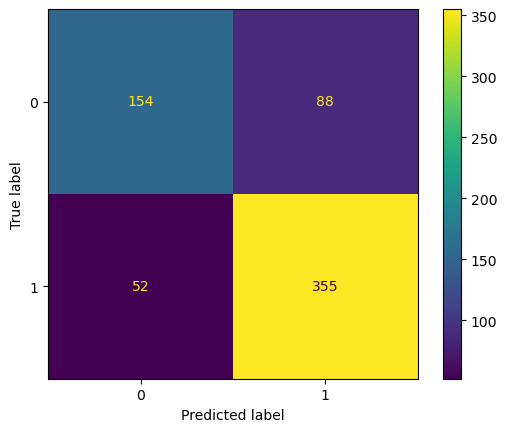

In [290]:
model = RandomForestClassifier(max_depth= 16, n_estimators=320, max_leaf_nodes= 190, min_samples_leaf= 5)
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

The Random Forest greatly improves performance with the tuned hyperparameters; let's see the XGB Boost model.

### XGBoost - Tuning & Hold-out Validation

In [44]:
search_space = {
    "n_estimators" : [300,350,400,450,500,550,600],
    "max_depth" : [3,4,5,6,7,8,9],
    "gamma" : [0.001,0.01,0.1],
    "learning_rate" : [0.001,0.01]
}

In [38]:
GS = GridSearchCV(estimator = XGBClassifier(use_label_encoder=False),
                  param_grid = search_space,
                  scoring = 'accuracy',
                  cv = 5,
                  verbose = 4)

In [39]:
#GS.fit(X_train,y_train)

In [40]:
#print(GS.best_params_) # to get only the best hyperparameter values that we searched for

Uncomment the following lines to enable the tuning. The best result I found was: gamma = 0.01, learning_rate = 0.01, max_depth = 5, n_estimators = 500

* **Default Hyperparameters**

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       242
           1       0.79      0.82      0.80       407

    accuracy                           0.75       649
   macro avg       0.73      0.73      0.73       649
weighted avg       0.75      0.75      0.75       649



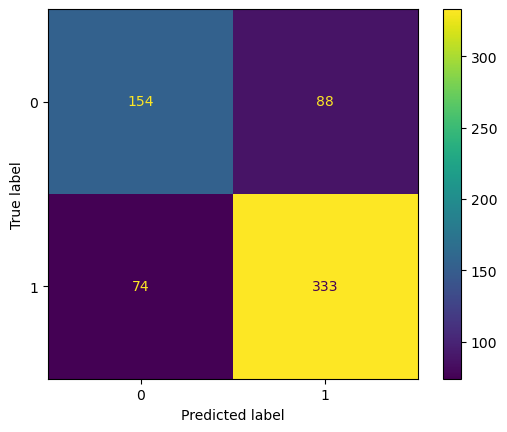

In [291]:
model = XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

* **Tuned Hyperparameters**

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       242
           1       0.80      0.85      0.83       407

    accuracy                           0.78       649
   macro avg       0.76      0.75      0.75       649
weighted avg       0.77      0.78      0.77       649



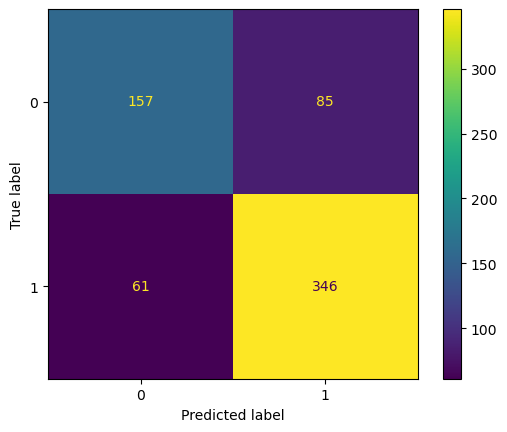

In [292]:
model = XGBClassifier(gamma=0.01,learning_rate=0.01, max_depth=5, n_estimators=500)
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

The model does not improve notably. However, we will use XGBoost model for the kockout prediction.

### Creating a pipeline for the XGBoost model

In [ ]:
pipe_X = pipe_knock_df.drop('Team1_Result',axis=1)
pipe_y = pipe_knock_df['Team1_Result']
pipe_knock = make_pipeline(column_trans,StandardScaler(with_mean=False),XGBClassifier(gamma=0.01,learning_rate=0.01, max_depth=5, n_estimators=500))
pipe_knock.fit(pipe_X,pipe_y)

In [ ]:
pipe_knock1 = make_pipeline(column_trans,StandardScaler(with_mean=False),RandomForestClassifier(max_depth= 16, n_estimators=320, max_leaf_nodes= 190, min_samples_leaf= 5))
pipe_knock1.fit(pipe_X,pipe_y)

In [296]:
joblib.dump(pipe_knock,"knockout_stage_prediction.pkl")

['knockout_stage_prediction.pkl']

In [297]:
joblib.dump(pipe_knock1,"knockout_stage_prediction1.pkl")

['knockout_stage_prediction1.pkl']